# 1. Import libraries

In [1]:
# !python -m pip install spacy==2.3.2 -q
# !python -m spacy download pl_core_news_lg
# !pip install transformers -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# data manipulation
import numpy as np
import pandas as pd
from collections import Counter
import re
import string

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# nltk
import nltk
nltk.download('wordnet')
import spacy
nlp = spacy.load('pl_core_news_lg')

# feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# models
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

# model evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, PrecisionRecallDisplay

# settings
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
articles_raw = pd.read_csv('drive/MyDrive/Articles.csv', index_col=0)
articles_raw['Date'] = pd.to_datetime(articles_raw['Date'], format='%Y-%m-%d')
articles_raw = articles_raw.loc[articles_raw['Date']<='2022-01-19', :]
articles_raw

,Date,Title,Content
0,2008-07-08,Brytyjscy deweloperzy na gwałt redukują biznes,\n\n \n\n\n\n Jeden pod drugim brytyjsc...
1,2008-07-09,"Polska gospodarka póki co odporna - 6,4 proc. PKB",\n\n \n\n\n\n Mamy kolejne potwierdzeni...
2,2008-07-11,"Szef MFW: najgorsze już minęło, ale przed gosp...",\n Szef Międzynarodowego Funduszu Walut...
3,2008-07-15,Nastroje we francuskim biznesie najgorsze od 5...,\n\n \n\n\n\n Nastroje we francuskim bi...
4,2008-07-16,Polska gospodarka dobrze sobie radzi i upadłoś...,\n Polska gospodarka nie odczuwa na raz...
...,...,...,...
26250,2022-01-19,Kowalczyk: przygotowujemy rozwiązanie ws. pobi...,"\n Przygotowujemy rozwiązanie, ..."
26251,2022-01-19,Minister Moskwa o Turowie: Jeśli Czesi potwier...,\n Jeżeli rząd czeski potwierdz...
26252,2022-01-19,Samsung zwiększa moce. Firma zainwestuje w zak...,\n Koreański producent zainwest...
26253,2022-01-19,Droższy nabiał i kawa. Średnia cena koszyka w ...,\n W grudniu średnia cena koszy...


In [5]:
articles_raw.isnull().mean()*100

Date       0.0
Title      0.0
Content    0.0
dtype: float64

In [6]:
wig_20_raw = pd.read_csv('drive/MyDrive/WIG_20.csv', index_col=0)
wig_20_raw.rename({'Data': 'Date', 'Zamkniecie': 'Close'}, axis=1, inplace=True)
wig_20_raw['Date'] = pd.to_datetime(wig_20_raw['Date'], format='%Y-%m-%d')
wig_20_raw = wig_20_raw.loc[wig_20_raw['Date']>=articles_raw['Date'].min(), ['Date', 'Close']]
wig_20_raw.reset_index(drop=True, inplace=True)
wig_20_raw

,Date,Close
0,2008-07-08,2549.94
1,2008-07-09,2588.55
2,2008-07-10,2557.66
3,2008-07-11,2517.32
4,2008-07-14,2520.69
...,...,...
3380,2022-01-13,2407.62
3381,2022-01-14,2383.16
3382,2022-01-17,2365.29
3383,2022-01-18,2317.36


# 2. Exploratory Data Analysis

### 2.1 Articles

##### Number of articles per month

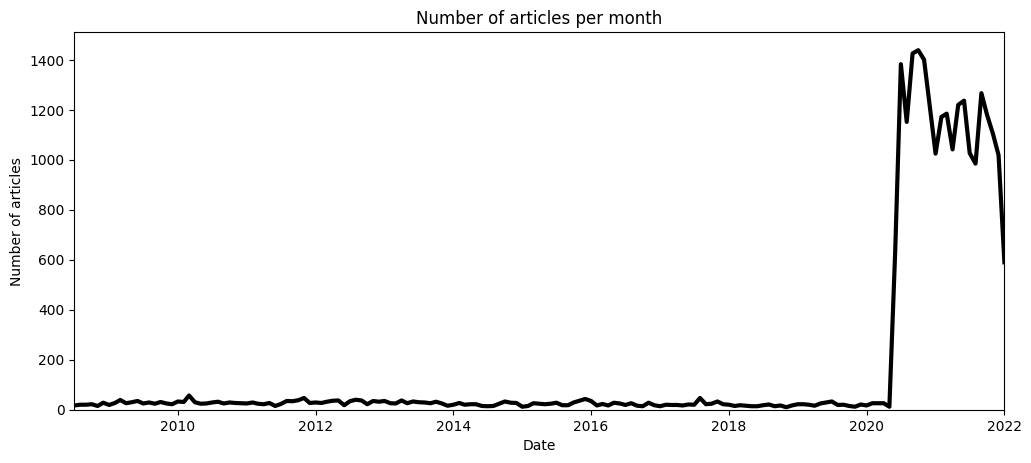

In [7]:
articles_months = articles_raw.copy()
articles_months['Date'] = articles_months["Date"].dt.strftime("%Y-%m")
articles_months = articles_months.groupby(['Date'])[['Date']].count().rename({'Date': 'Count'}, axis=1)
articles_months.index = pd.to_datetime(articles_months.index, format='%Y-%m')
articles_months

plt.figure(figsize=(12, 5), dpi=100)
plt.plot(articles_months['Count'], color='black', linewidth=3)

plt.xlim([articles_months.index.min(), articles_months.index.max()])
plt.ylim([0, articles_months['Count'].max()*1.05])
plt.ylabel('Number of articles')
plt.xlabel('Date')
plt.title('Number of articles per month')
plt.show()

##### Length of articles

In [8]:
articles_raw['Content'].str.len().describe([0.75, 0.9, 0.95])

count    26255.000000
mean      3182.688059
std       2417.688336
min        245.000000
50%       2588.000000
75%       3888.000000
90%       5643.000000
95%       7338.300000
max      39270.000000
Name: Content, dtype: float64

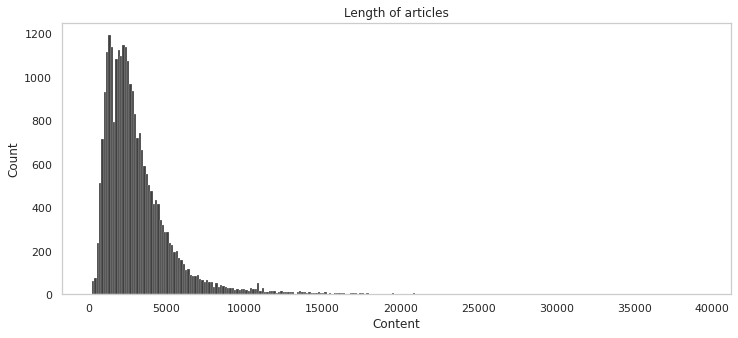

In [9]:
sns.set(rc = {'figure.figsize':(12,5)})
sns.set_style("whitegrid", {'axes.grid' : False})
sns.histplot(articles_raw['Content'].str.len(), color='black')
plt.title('Length of articles')
plt.show()

### 2.2 WIG20

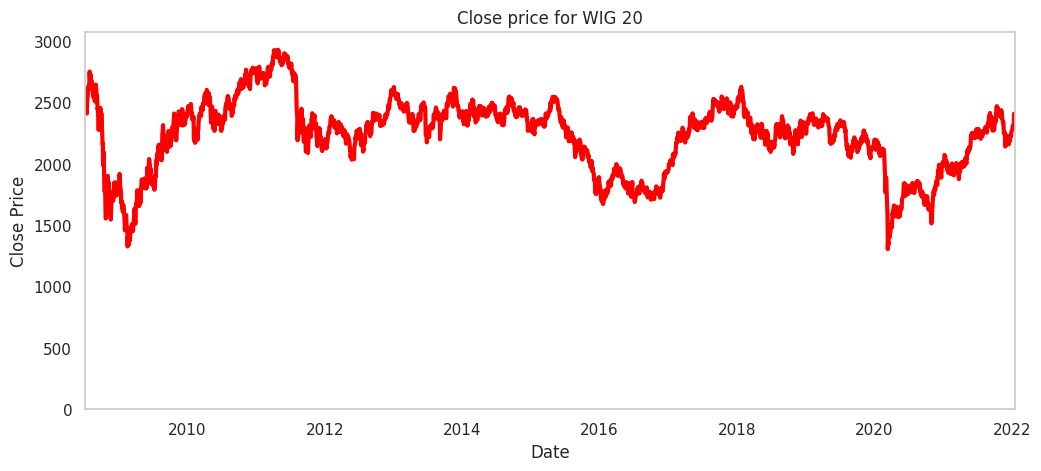

In [10]:
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(wig_20_raw['Date'], wig_20_raw['Close'], color='red', linewidth=3)

plt.xlim([wig_20_raw['Date'].min(), wig_20_raw['Date'].max()])
plt.ylim([0, wig_20_raw['Close'].max()*1.05])
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title('Close price for WIG 20')
plt.show()

# 3. Data preparation

### 3.1 Mering the data and creating our target (whether the index will increase)

Our model will predict from the article whether the WIG20 will rise (**1**) or not (**0**) in the next month (average 4 weeks). 

In [11]:
wig_20 = wig_20_raw.copy()

# I shift it by 20 working days, of course there is no value for the first days - I am going to remove these days.
wig_20['Increase'] = wig_20['Close'].shift(-20)
wig_20.dropna(inplace=True)

def increase_decrease(row):
    if row['Increase'] > row['Close']:
        return 1
    elif row['Increase'] <= row['Close']:
        return 0

wig_20['Increase'] = wig_20.apply(increase_decrease, axis=1)

# The articles are written daily, so you need to add values for Saturday and Sunday (the exchange does not operate on those days).
wig_20.set_index('Date', inplace=True)
new_dates = pd.date_range(wig_20.index.min(), wig_20.index.max(), freq='d')
wig_20 = wig_20.reindex(new_dates)
wig_20 = wig_20.fillna(method='ffill')
wig_20.reset_index(inplace=True)
wig_20.rename({'index': 'Date'}, axis=1, inplace=True)

wig_20

,Date,Close,Increase
0,2008-07-08,2549.94,1.0
1,2008-07-09,2588.55,1.0
2,2008-07-10,2557.66,1.0
3,2008-07-11,2517.32,1.0
4,2008-07-12,2517.32,1.0
...,...,...,...
4906,2021-12-13,2214.38,1.0
4907,2021-12-14,2211.81,1.0
4908,2021-12-15,2161.04,1.0
4909,2021-12-16,2213.89,1.0


Now we need to check if our classes are balanced:

In [12]:
wig_20['Increase'].value_counts(normalize=True)

1.0    0.518021
0.0    0.481979
Name: Increase, dtype: float64

It's not perfect, but we can assume that the classes are balanced. After merging the data with the articles, we will again need to check if they are balanced as we have different number of articles per month/year.



In [13]:
prepared_dataset = pd.merge(articles_raw, wig_20, on=['Date'], how='inner')
prepared_dataset.set_index('Date', inplace=True)
prepared_dataset = prepared_dataset.loc[: ,['Content', 'Increase']]

prepared_dataset

,Content,Increase
Date,,
2008-07-08,\n\n \n\n\n\n Jeden pod drugim brytyjsc...,1.0
2008-07-09,\n\n \n\n\n\n Mamy kolejne potwierdzeni...,1.0
2008-07-11,\n Szef Międzynarodowego Funduszu Walut...,1.0
2008-07-15,\n\n \n\n\n\n Nastroje we francuskim bi...,1.0
2008-07-16,\n Polska gospodarka nie odczuwa na raz...,1.0
...,...,...
2021-12-17,\n Czwartkowa sesja na Wall Str...,1.0
2021-12-17,\n Pod pomnikiem Ofiar Grudnia ...,1.0
2021-12-17,\n Jarosław Kaczyński już dawno...,1.0


In [14]:
prepared_dataset['Increase'].value_counts(normalize=True)

1.0    0.609363
0.0    0.390637
Name: Increase, dtype: float64

The data is slightly unbalanced - keep that in mind.

### 3.2 Cleaning

In [15]:
pl_stopwords = nlp.Defaults.stop_words

In [16]:
punctuations_list = string.punctuation
translator = str.maketrans('', '', punctuations_list) 

In [17]:
def clean_text(text):
    text = text.lower()
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    text = text.translate(translator)
    text = re.sub(r'(.)1+', r'1', text)
    text = re.sub('\t', '', text)
    text = re.sub('((www.[^s]+)|(https?://[^s]+))',' ', text)
    text = re.sub('[0-9]+', '', text)
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    text = nlp(text)
    text = ' '.join([token.lemma_ for token in text if token.lemma_ not in pl_stopwords])
    return text 

In [18]:
cleaned_dataset = prepared_dataset.copy()
cleaned_dataset['Content'] = cleaned_dataset['Content'].apply(clean_text)
print('Before:')
display(prepared_dataset.head(3))
print('After:')
display(cleaned_dataset.head(3))

Before:


,Content,Increase
Date,,
2008-07-08,\n\n \n\n\n\n Jeden pod drugim brytyjsc...,1.0
2008-07-09,\n\n \n\n\n\n Mamy kolejne potwierdzeni...,1.0
2008-07-11,\n Szef Międzynarodowego Funduszu Walut...,1.0


After:


,Content,Increase
Date,,
2008-07-08,drugi brytyjski deweloper popadać kłopot lider...,1.0
2008-07-09,mieć kolejny potwierdzenie zawirowanie międzyn...,1.0
2008-07-11,szef międzynarodowy fundusz walutowy dominique...,1.0


In [19]:
prepared_dataset.iloc[0, 0]

"\n\n \n\n\n\n        Jeden pod drugim brytyjscy deweloperzy popadają w kłopoty. Po liderze branży Taylor Wimpel numer dwa na wyspach – firma Persimmon zapowiedziała zwolnienie 20 proc. załogi\n    \n\n\n\n\n\n\ngoogletag.cmd.push(function() { googletag.display('banner_w_artykule'); });\n\nReklama\n\n\n\n\n\n\nNajgorszy kryzys na rynku nieruchomości w Wielkiej Brytanii sprawił, że sprzedaż Persimmona w I półroczu spadła o 34 proc. Drugi potentat budowlany na Wsypach postanowił zwolnić 1100 pracowników, czyli jedną piątą załogi.\n\n\nJuż w zeszłym roku notowania spółki Persimmon obniżyły się dramatycznie, bo o 72 proc. We wtorek walory firmy znowu potaniały w Londynie o 8,2 proc.\n\n\nZ raportu spółki wynika, że sprzedaż pod względem wartościowym obniżyła się w rozliczanym okresie o 31 proc. do 5.501 domów, a średnia cena kupowanego obiektu spadła do 181,5 tys funtów wobec 189,255 tys. funtów przed rokiem.\n\n\nW ślad za coraz gorszymi warunkami na rynku liczba rezerwacji przez klientów

In [20]:
cleaned_dataset.iloc[0, 0]

'drugi brytyjski deweloper popadać kłopot lider branża taylor wimpel numer wyspa firma persimmon zapowiedzieć zwolnienie proc załóg googletagcmdpushfunction googletagdisplaybannerwartykule reklama zły kryzys rynek nieruchomość wielki brytania sprawić sprzedaż persimmona półrocze spaść proc drugi potentat budowlany wsypa postanowić zwolnić pracownik piąty załóg zeszły rok notowanie spółka persimmon obniżyć dramatycznie proc wtorek walor firma potanieć londynie proc raport spółka wynikać sprzedaż wzgląd wartościowy obniżyć rozliczanym okres proc dom średni cena kupować obiekt spaść funt wobec funt rok ślad zły warunki rynek liczba rezerwacja klient spaść proc liczba anulować umowa wzrość proca porównanie proca rok firma budowlany musić zredukować koszt spisywać wartość grunt inwestycyjny warunki szybki spadek cena dom możliwość realny poprawa rynek perspektywa rok twierdzić analityk merrill lynch wielki dom maklerski usa tb bloomberg'

### 3.3 N-gram

It is useful to see if there are class-specific words (or phrases).

In [21]:
def ngrams(text, n):
    return [" ".join(x) for x in zip(*[text[i:] for i in range(n)])]

def get_top_ngrams(series, ngrams_range=2, top_n=5):
    all_ngrams = series['Content'].map(lambda x: ngrams(x.strip().lower().split(), ngrams_range)).sum()
    return Counter(all_ngrams).most_common(top_n)

def plot_ngrams(df, labels, ngrams_range, top_n):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    axes = axes.flatten()

    for i, label in enumerate(labels):
        top_ngrams_freq = get_top_ngrams(df[df['Increase'] == label], ngrams_range=ngrams_range, top_n=top_n)
        top_ngrams = [ngram for ngram, _ in top_ngrams_freq]
        freqs = [freq for _, freq in top_ngrams_freq]
        sns.barplot(x=freqs, y=top_ngrams, ax=axes[i])
        axes[i].set_title(label)

    plt.tight_layout()

###### 3.3.1 Bigrams

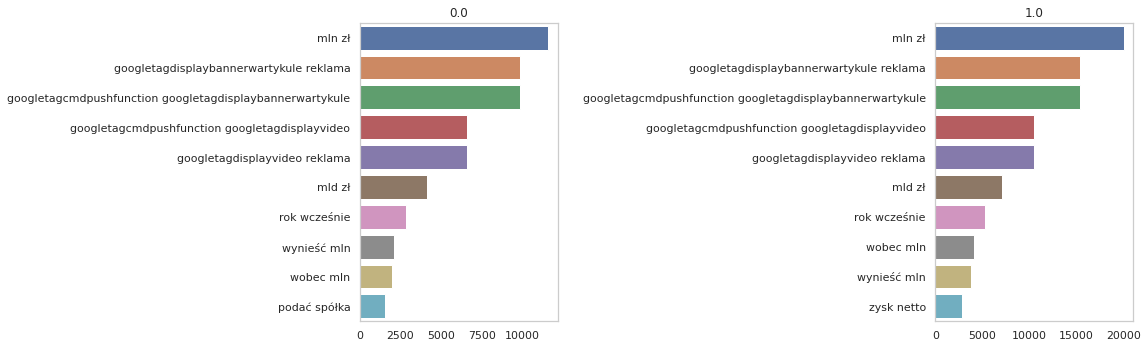

In [22]:
plot_ngrams(cleaned_dataset, set(cleaned_dataset['Increase']), 2, 10)

###### 3.3.2 Trigrams

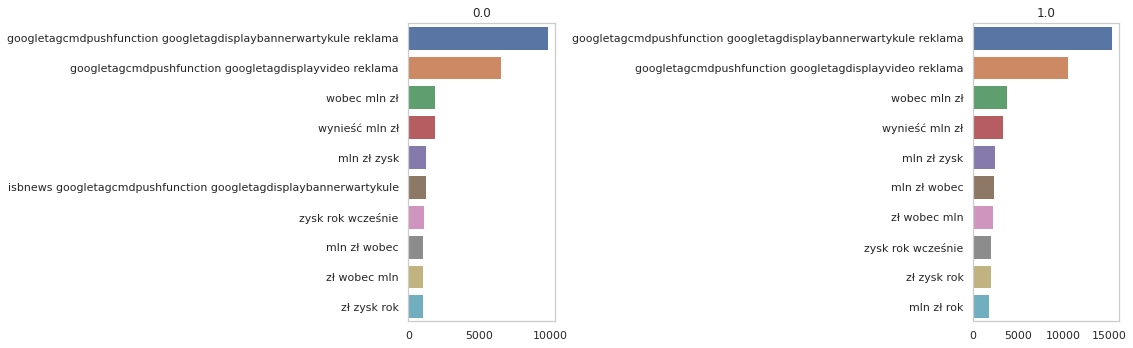

In [23]:
plot_ngrams(cleaned_dataset, set(cleaned_dataset['Increase']), 3, 10)

It didn't help :)

### 3.4 Tag Cloud

In [24]:
cleaned_dataset.Content = cleaned_dataset.Content.astype(str)
cleaned_dataset

,Content,Increase
Date,,
2008-07-08,drugi brytyjski deweloper popadać kłopot lider...,1.0
2008-07-09,mieć kolejny potwierdzenie zawirowanie międzyn...,1.0
2008-07-11,szef międzynarodowy fundusz walutowy dominique...,1.0
2008-07-15,nastrój francuski biznes zły rok wskaźnik zauf...,1.0
2008-07-16,polski gospodarka odczuwać globalny kłopot pro...,1.0
...,...,...
2021-12-17,czwartkowy sesja wall street zakończyć spadek ...,1.0
2021-12-17,pomnik ofiara grudzień niedaleko stacja szybki...,1.0
2021-12-17,jarosław kaczyński dawno rządzić panować nica ...,1.0


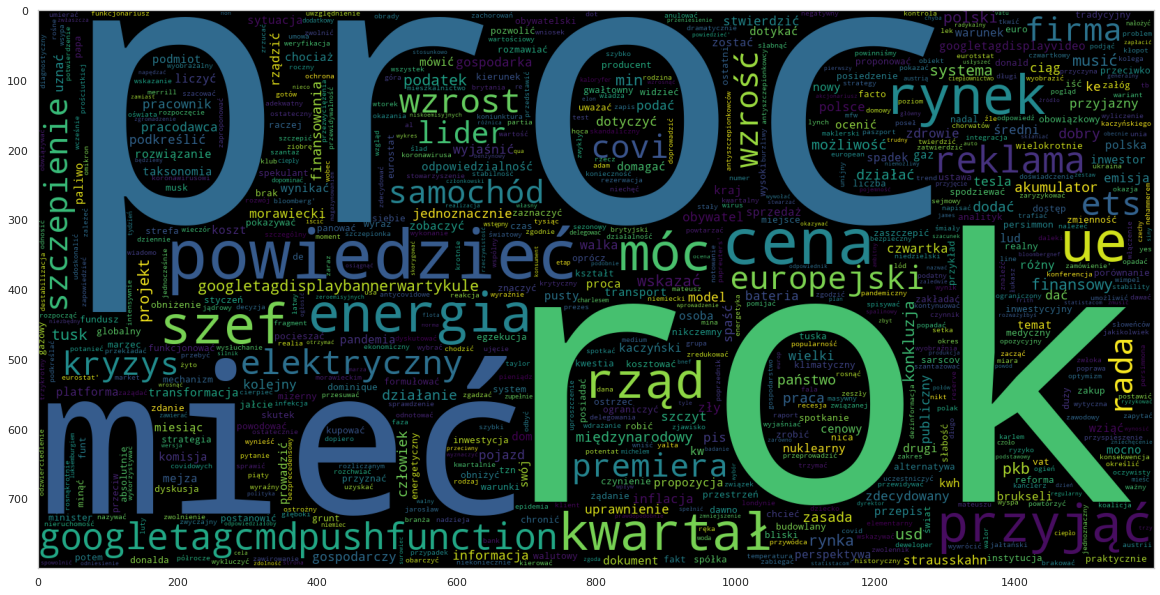

In [25]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(str(cleaned_dataset.Content.values))
plt.imshow(wc)

### 3.5 Train Test Split

In [26]:
first_test_date = pd.datetime.strptime('2021-07-01', '%Y-%m-%d')

print('Train dataset:')
train_dataset = cleaned_dataset.loc[cleaned_dataset.index<first_test_date, :].copy()
print(train_dataset['Increase'].value_counts(normalize=True))
print('Result after Under-Sampling:')
class_count_1_train, class_count_0_train = train_dataset['Increase'].value_counts()
class_0_train = train_dataset[train_dataset['Increase'] == 0]
class_1_train = train_dataset[train_dataset['Increase'] == 1]
class_1_under_train = class_1_train.sample(class_count_0_train)
train_dataset = pd.concat([class_1_under_train, class_0_train], axis=0)
print(train_dataset['Increase'].value_counts(normalize=True))
train_dataset.sort_index(axis = 0, inplace=True)
display(train_dataset)

print('Test dataset:')
test_dataset = cleaned_dataset.loc[cleaned_dataset.index>=first_test_date, :].copy()
print(test_dataset['Increase'].value_counts(normalize=True))
print('Result after Under-Sampling:')
class_count_1_test, class_count_0_test = test_dataset['Increase'].value_counts()
class_0_test = test_dataset[test_dataset['Increase'] == 0]
class_1_test = test_dataset[test_dataset['Increase'] == 1]
class_1_under_test = class_1_test.sample(class_count_0_test)
test_dataset = pd.concat([class_1_under_test, class_0_test], axis=0)
print(test_dataset['Increase'].value_counts(normalize=True))
test_dataset.sort_index(axis = 0, inplace=True)
display(test_dataset)

Train dataset:
1.0    0.604654
0.0    0.395346
Name: Increase, dtype: float64
Result after Under-Sampling:
0.0    0.5
1.0    0.5
Name: Increase, dtype: float64


,Content,Increase
Date,,
2008-07-11,szef międzynarodowy fundusz walutowy dominique...,1.0
2008-07-15,nastrój francuski biznes zły rok wskaźnik zauf...,1.0
2008-07-16,polski gospodarka odczuwać globalny kłopot pro...,1.0
2008-07-17,chiński gospodarka rość wolny tempo pkb wzrość...,1.0
2008-07-21,bank millennium podtrzymywać cela biznesowy fi...,0.0
...,...,...
2021-06-30,środowy sesja giełdowy stać znak mocny przecen...,1.0
2021-06-30,artykuł dziennik frankfurter allgemeine zeitun...,1.0
2021-06-30,janosikowy element system finanse samorządowy ...,1.0


Test dataset:
1.0    0.623889
0.0    0.376111
Name: Increase, dtype: float64
Result after Under-Sampling:
0.0    0.5
1.0    0.5
Name: Increase, dtype: float64


,Content,Increase
Date,,
2021-07-01,komputronik restrukturyzacja odnotować mln zł ...,1.0
2021-07-01,square games podpisać akcjonariusz rortos umow...,1.0
2021-07-01,rząd bułgarii bank centralny opublikować plan ...,1.0
2021-07-01,wielki brytania lipiec wchodzić żyto prawo nap...,1.0
2021-07-01,akcjonariusz dekpolu zdecydować walny zgromadz...,1.0
...,...,...
2021-12-17,budżet kłamstwo nierealny wykonanie mieć chara...,1.0
2021-12-17,czwartkowy sesja wall street zakończyć spadek ...,1.0
2021-12-17,budżet budżet przejściowy widać walka pandemia...,1.0


In [27]:
X_train = train_dataset.Content
y_train = train_dataset.Increase

X_test = test_dataset.Content
y_test = test_dataset.Increase

# 4. Modelling and Evaluation

The task is an exploration of the methods using in NLP, so we will not focus on the selection of hyperparameters.

In [28]:
def model_Evaluate(model, X_test_set, y_test_set):
    # Data prediction on test data
    y_pred = model.predict(X_test_set)

    # Display evaluation metrics based on prediction and ground truth (actual labels)
    print(classification_report(y_test_set, y_pred))

    # We calculate and display the confusion matrix
    cf_matrix = confusion_matrix(y_test_set, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '', xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall
    PrecisionRecallDisplay.from_predictions(y_test, y_pred)
    plt.title('Precision-Recall')
    plt.show()

### 4.1. Simple ML model

##### 4.1.1 Vectorization of words using the tool TF-IDF Vectorizer

In [29]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

No. of feature_words:  500000


In [30]:
X_train_vectorizer = vectorizer.transform(X_train)
X_test_vectorizer  = vectorizer.transform(X_test)

##### 4.1.2 Train and Evaluate model

4.1.2.1 Naive Bayes - Bernoulli

              precision    recall  f1-score   support

         0.0       0.50      0.54      0.52      2327
         1.0       0.50      0.45      0.47      2327

    accuracy                           0.50      4654
   macro avg       0.50      0.50      0.50      4654
weighted avg       0.50      0.50      0.50      4654



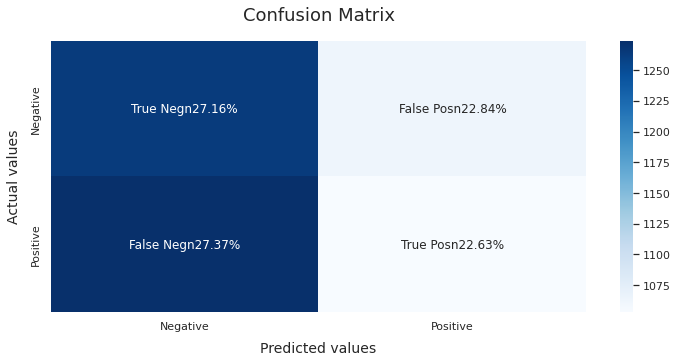

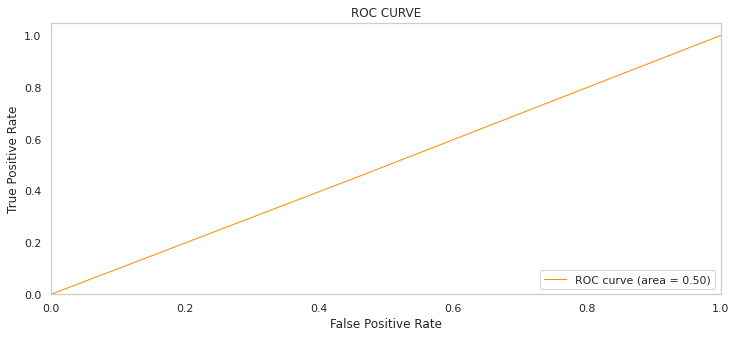

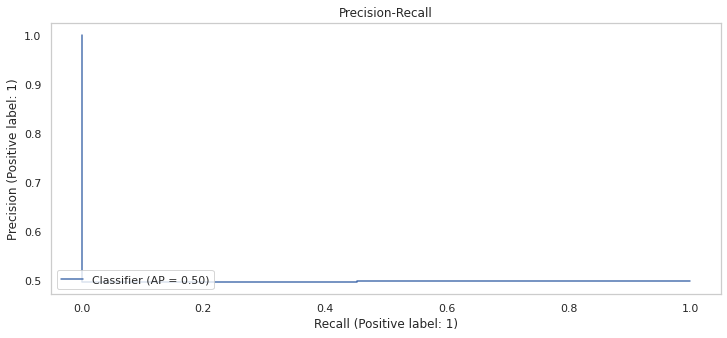

In [31]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_vectorizer, y_train)
model_Evaluate(BNBmodel, X_test_vectorizer, y_test)

4.1.2.2 Logistic Regression

              precision    recall  f1-score   support

         0.0       0.47      0.41      0.44      2327
         1.0       0.47      0.53      0.50      2327

    accuracy                           0.47      4654
   macro avg       0.47      0.47      0.47      4654
weighted avg       0.47      0.47      0.47      4654



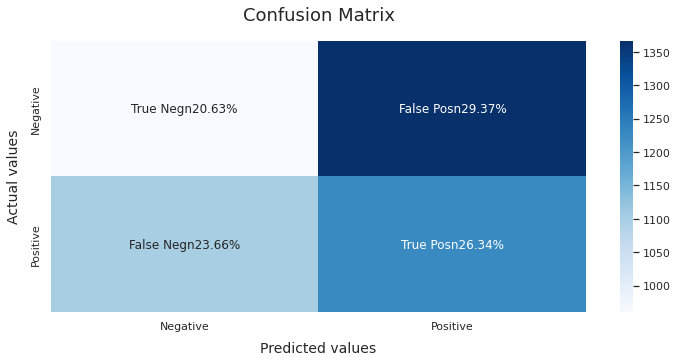

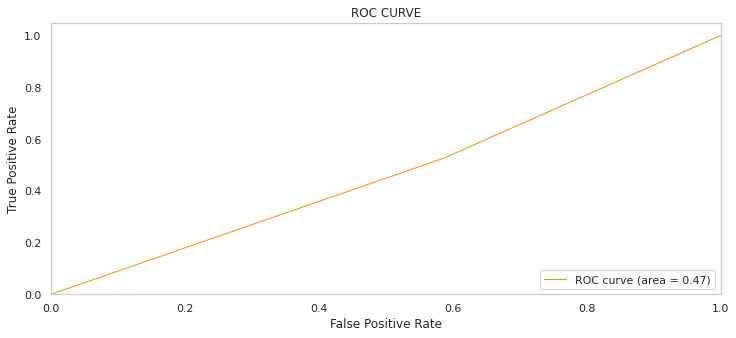

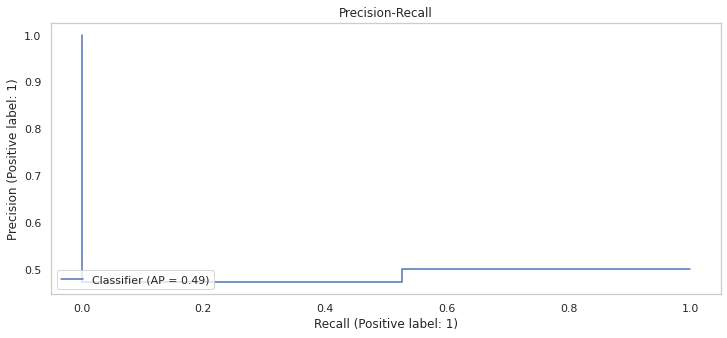

In [32]:
LRmodel = LogisticRegression(max_iter = 1000)
LRmodel.fit(X_train_vectorizer, y_train)
model_Evaluate(LRmodel, X_test_vectorizer, y_test)

4.1.2.3 Random Forest



              precision    recall  f1-score   support

         0.0       0.49      0.44      0.46      2327
         1.0       0.49      0.53      0.51      2327

    accuracy                           0.49      4654
   macro avg       0.49      0.49      0.49      4654
weighted avg       0.49      0.49      0.49      4654



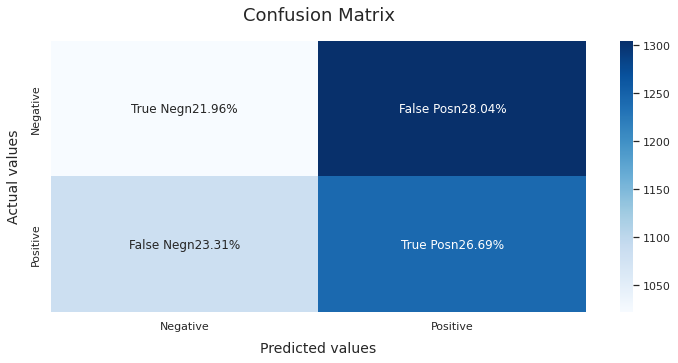

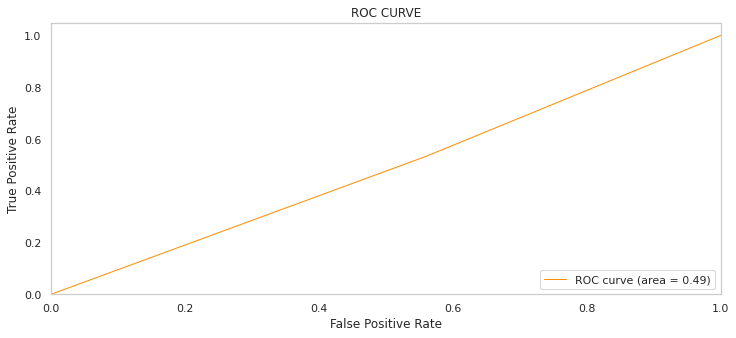

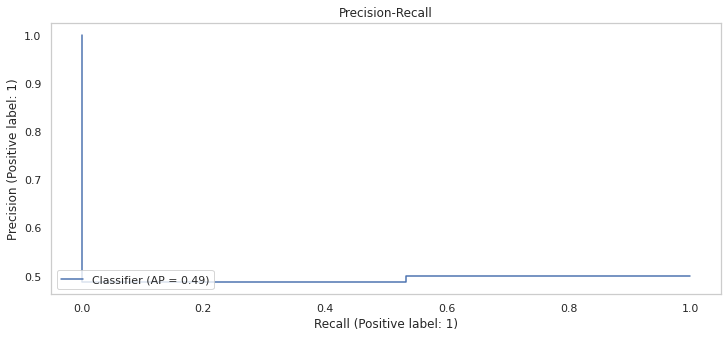

In [33]:
RFmodel = RandomForestClassifier(n_estimators=1000)
RFmodel.fit(X_train_vectorizer, y_train)
model_Evaluate(RFmodel, X_test_vectorizer, y_test)

### 4. 2 NN

##### 4.2.1 Converting text to tensors

In [34]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_tensor = tokenizer.texts_to_sequences(X_train)
X_train_tensor = pad_sequences(X_train_tensor, maxlen=max_len)
print('Train Shape')
print(f'X: {X_train_tensor.shape}')
print(f'y: {y_train.shape}')

X_test_tensor = tokenizer.texts_to_sequences(X_test)
X_test_tensor = pad_sequences(X_test_tensor, maxlen=max_len)
print('\nTest Shape')
print(f'X: {X_test_tensor.shape}')
print(f'y: {y_test.shape}')

Train Shape
X: (15088, 200)
y: (15088,)

Test Shape
X: (4654, 200)
y: (4654,)


##### 4.2.2 Train model

In [35]:
model_nn = Sequential()
model_nn.add(layers.Embedding(max_words, 20))
model_nn.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model_nn.add(layers.Dense(1, activation='sigmoid'))


model_nn.compile(optimizer='rmsprop',
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])


checkpoint = ModelCheckpoint("best_model.hdf5", 
                              monitor='val_accuracy',
                              save_best_only=True,
                              mode='auto',
                              save_weights_only=False)

history = model_nn.fit(X_train_tensor, 
                       y_train, 
                       epochs=70,
                       validation_data=(X_test_tensor, y_test),
                       callbacks=[checkpoint])

Epoch 1/70
472/472 [==============================] - 45s 79ms/step - loss: 0.0000e+00 - accuracy: 0.4997 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 2/70
472/472 [==============================] - 36s 77ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 3/70
472/472 [==============================] - 36s 77ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 4/70
472/472 [==============================] - 36s 77ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 5/70
472/472 [==============================] - 36s 77ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 6/70
472/472 [==============================] - 36s 76ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 7/70
472/472 [==============================] - 36s 76ms/step - loss: 0.0000e+00 -

In [36]:
best_model = keras.models.load_model("best_model.hdf5")

In [37]:
test_loss, test_acc = best_model.evaluate(X_test_tensor, y_test, verbose=2)
print('Model accuracy: ',test_acc)

146/146 - 5s - loss: 0.0000e+00 - accuracy: 0.5000 - 5s/epoch - 32ms/step
Model accuracy:  0.5


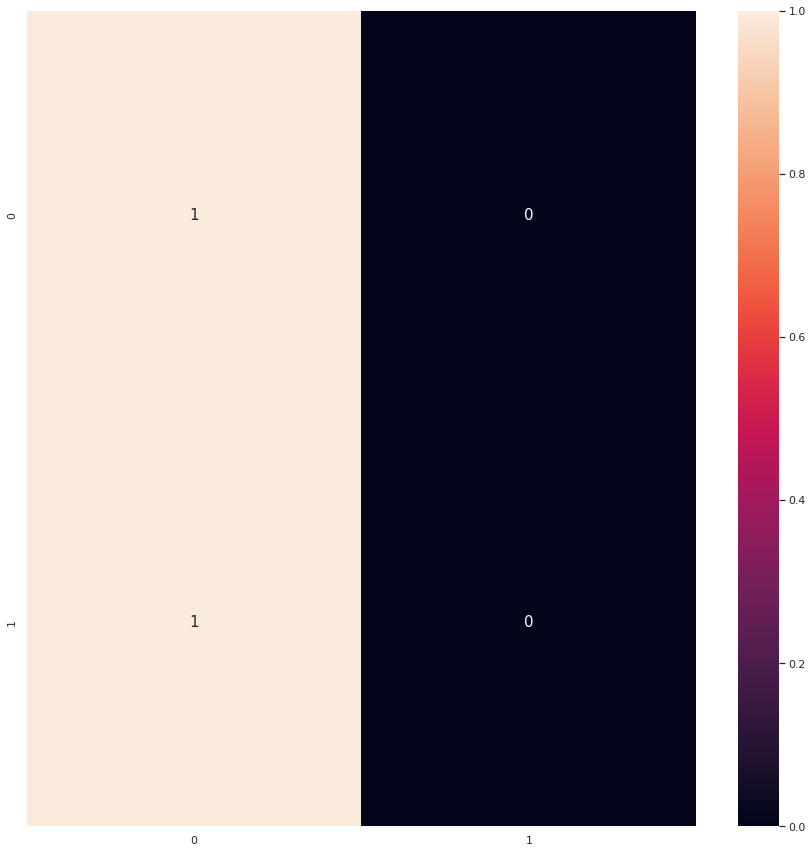

In [38]:
predictions = best_model.predict(X_test_tensor)
matrix = confusion_matrix(y_test, np.around(predictions, decimals=0).argmax(axis=1))

conf_matrix = pd.DataFrame(matrix, index = ['0','1'],columns = ['0','1'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})
plt.show()

### 4.3 BERT

In [39]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [50]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [39]:
import tensorflow as tf

In [46]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None,
                                                            text_a = x[DATA_COLUMN], 
                                                            text_b = None,
                                                            label = x[LABEL_COLUMN]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None,
                                                            text_a = x[DATA_COLUMN], 
                                                            text_b = None,
                                                            label = x[LABEL_COLUMN]), axis = 1)

    return train_InputExamples, validation_InputExamples




def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            padding=True,
            truncation=True
        )

        
        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    
    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [51]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train_dataset, test_dataset, 'Content', 'Increase')

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

In [59]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
    )

model.fit(train_data, epochs=10, validation_data=validation_data)

Epoch 1/10
      2/Unknown - 31s 1s/step - loss: 3.8102 - accuracy: 0.8125 

InvalidArgumentError: ignored